In [28]:
import urllib.request
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = urllib.request.urlopen('https://raw.githubusercontent.com/karpathy/makemore/master/names.txt').read().decode('utf-8').splitlines()

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [29]:
# make dataset
def build_dataset(words):
  block_size = 3
  X, Y = [], []

  for word in words:
    context = [0] * block_size
    word += '.'
    for ch in word:
      X.append(context)
      idx = stoi[ch]
      Y.append(idx)
      #for ctxt in context:
      #  print(itos[ctxt], end='')
      #print(''.join(itos[ctxt] for ctxt in context), '--->', ch)
      context = context[1:] + [idx]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
train_words = words[:n1]
dev_words = words[n1:n2]
test_words = words[n2:]
Xtrain, Ytrain = build_dataset(train_words)
Xdev, Ydev = build_dataset(dev_words)
Xtest, Ytest = build_dataset(test_words)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
Xtest.shape, Ytest.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [8]:
xenc = F.one_hot(X).float()
xenc.shape

torch.Size([228146, 3, 27])

In [9]:
C = torch.randn(27, 2)

In [10]:
(xenc @ C).shape

torch.Size([228146, 3, 2])

In [11]:
# simple lookup. no need to do dot product
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [12]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100,))
print(W1.shape)
print(b1.shape)

torch.Size([6, 100])
torch.Size([100])


In [13]:
#need to compress last 2 dimensions into 1 of emb
#emb = torch.cat(torch.unbind(emb, dim=1), 1).shape
# much simpler way
emb = emb.reshape(emb.shape[0], -1)
emb.shape

torch.Size([228146, 6])

In [14]:
h = torch.tanh(emb @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [15]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27,))
print(W2.shape)
print(b2.shape)

torch.Size([100, 27])
torch.Size([27])


In [16]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [17]:
probs = torch.softmax(logits, dim=1)
probs.shape

torch.Size([228146, 27])

In [18]:
loss = -probs[torch.arange(len(Y)), Y].log().mean()
loss

tensor(17.6403)

# rewrite clean

In [73]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27, 10, generator=g, requires_grad=True)
W1 = torch.randn((30, 100), generator=g, requires_grad=True)
b1 = torch.randn((100,), generator=g, requires_grad=True)
W2 = torch.randn((100, 200), generator=g, requires_grad=True)
b2 = torch.randn((200,), generator=g, requires_grad=True)
W3 = torch.randn((200, 27), generator=g, requires_grad=True)
b3 = torch.randn((27,), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2, W3, b3]

p_size = sum(p.nelement() for p in parameters)
print(f"{p_size=}")

p_size=28997


In [76]:
lossi = []
stepi = []

for i in range(50000):
  #mini batch
  ix = torch.randint(0, Xtrain.shape[0], (64,))
  X_batch = Xtrain[ix]
  Y_batch = Ytrain[ix]
  ##forward
  emb = C[X_batch]
  emb = emb.reshape(emb.shape[0], -1)
  h1 = torch.tanh(emb @ W1 + b1)
  h2 = torch.tanh(h1 @ W2 + b2)
  logits = h2 @ W3 + b3
  #probs = torch.softmax(logits, dim=1)
  #loss = -probs[torch.arange(len(Y)), Y].log().mean()
  loss = F.cross_entropy(logits, Y_batch)

  # backward
  for p in parameters:
    p.grad = None
  loss.backward()

  # grad descent
  lr = 0.1 if i < 40000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track
  lossi.append(loss.log10().item())
  stepi.append(i)

  if i%10000 == 0:
    print(loss.item())
print(loss.item())

4.0549750328063965
2.1394290924072266
2.2619316577911377
2.1970202922821045
2.173630714416504
2.0792036056518555


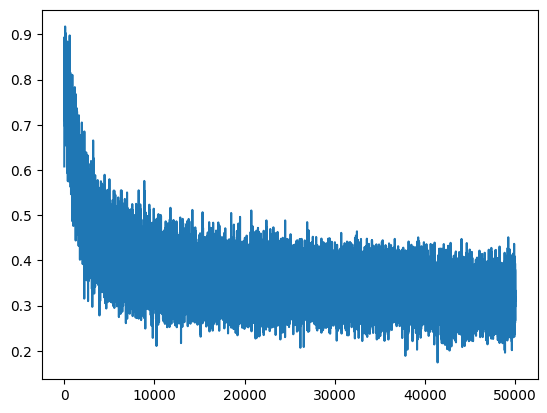

In [77]:
plt.plot(stepi, lossi)

In [78]:
#dev
emb = C[Xdev]
emb = emb.reshape(emb.shape[0], -1)
h1 = torch.tanh(emb @ W1 + b1)
h2 = torch.tanh(h1 @ W2 + b2)
logits = h2 @ W3 + b3
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1932005882263184
